In [ ]:
!gdown 1wrN9NmwD8xUk2TXqVqk661ekyHm_2wFB
!gdown 1Y5dsLErTYpyavcaSBE2sVm5AMBGGFJq5
!gdown 1rsmxEm0mZzVXpbE3HYERbRn1jxDmEvFX
!gdown 1YthtVP80XjD7afCiL7FHZsmbjWgnuSln

Downloading...
From: https://drive.google.com/uc?id=1wrN9NmwD8xUk2TXqVqk661ekyHm_2wFB
To: /content/test_images.npy
100% 7.84M/7.84M [00:00<00:00, 82.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Y5dsLErTYpyavcaSBE2sVm5AMBGGFJq5
To: /content/test_labels.npy
100% 10.1k/10.1k [00:00<00:00, 23.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rsmxEm0mZzVXpbE3HYERbRn1jxDmEvFX
To: /content/train_images.npy
100% 47.0M/47.0M [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YthtVP80XjD7afCiL7FHZsmbjWgnuSln
To: /content/train_labels.npy
100% 60.1k/60.1k [00:00<00:00, 37.2MB/s]


In [ ]:
import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt

In [ ]:
cfg = {
    'lr': 0.01,
    'weight_decay': 0.0001, # prevents overfitting
    'momentum': 0.9,
    'nesterov': True,
    'epochs': 20,
    'batch_size': 64,
    'log_every': 1,
    'val_every': 1,
    'num_workers': 4,
    'patience': 5, # This parameter determines the number of epochs with no improvement in the monitored metric (test set accuracy) after which the learning rate will be reduced. If the monitored metric does not improve for the specified number of epochs, the scheduler considers it as a lack of progress and reduces the learning rate.
    'lr_decay': 0.5 # This parameter controls the factor by which the learning rate will be reduced. For example, if factor=0.1, the learning rate will be reduced by a factor of 0.1 when the specified patience is reached.
}

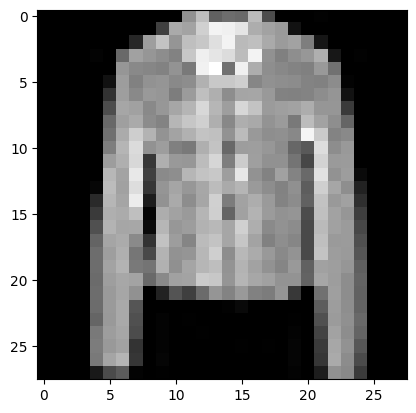

In [ ]:
# TODO: Define your data path (the directory containing the 4 np array files)
DATA_PATH = "/content"

class FMNIST(Dataset):
    def __init__(self, set_name): # set_name is either test or train
        super().__init__()
        # TODO: Retrieve all the images and the labels, and store them
        # as class variables. Maintaing any other class variables that
        # you might need for the other class methods. Note that the
        # methods depends on the set (train or test) and thus maintaining
        # that is essential.
        self.set_name = set_name
        # Retrieve the file paths
        images_file = os.path.join(DATA_PATH, f'{set_name}_images.npy')
        labels_file = os.path.join(DATA_PATH, f'{set_name}_labels.npy')

        # Load the dataset files
        self.images_array = np.load(images_file)
        self.images = torch.from_numpy(np.load(images_file).astype(np.float32) / 255.0)  # Scale images to [0, 1]
        self.labels = torch.from_numpy(np.load(labels_file))
        self.n_samples = self.images.shape[0]
        #

    def __len__(self): # returns total number of samples in the dataset
        # TODO: Complete this
        return self.n_samples


    def __getitem__(self, index):
        # TODO: Complete this
        image = self.images[index]
        label = self.labels[index]

        return image,label



def get_data_loader(set_name):
    # TODO: Create the dataset class tailored to the set (train or test)
    # provided as argument. Use it to create a dataloader. Use the appropriate
    # hyper-parameters from cfg
    dataset = FMNIST(set_name)
    dataLoader = DataLoader(dataset=dataset, batch_size=cfg["batch_size"],shuffle=True,num_workers=cfg["num_workers"])
    return dataLoader


dataset = FMNIST("test")
plt.imshow(dataset.images_array[10], cmap = 'gray')
plt.show()



In [ ]:
def xavier_init(param):
    # NOTE: Not for Vanilla Classifier
    # TODO: Complete this to initialize the weights
    if param.dim() > 1: # for weights
        torch.nn.init.xavier_normal_(param)
    else: # for bias
        param.data.fill_(0)


def zero_init(param):
    # NOTE: Not for Vanilla Classifier
    # TODO: Complete this to initialize the weights

    if param.dim() > 1: # for weights
        torch.nn.init.zeros_(param)
    else: # for bias
        param.data.fill_(0)

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # TODO: Define the model architecture here

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.Softmax(dim=1)
        )

        # NOTE: Not for Vanilla Classsifier
        # TODO: Initalize weights by calling the
        # init_weights method
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
           if isinstance(m, nn.Linear):
            xavier_init(m.weight)
            xavier_init(m.bias)


    # def _init_weights(self, module):
    #     if isinstance(module, nn.Linear):
    #         xavier_init(module.weight)
    #         xavier_init(module.bias)


    def forward(self, x):
        # TODO: Define the forward function of your model
        x = self.model(x)
        return x

    def save(self, ckpt_path):
        # TODO: Save the checkpoint of the model
        torch.save(self.state_dict(), ckpt_path)

    def load(self, ckpt_path):
        # TODO: Load the checkpoint of the model
        self.load_state_dict(torch.load(ckpt_path))
        # self.eval()

# network = Network()
# # print(network)

# for name, param in network.named_parameters():
#     print(f"Layer: {name}, Size: {param.shape}")

In [ ]:
try:
    from termcolor import cprint
except ImportError:
    cprint = None

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

def log_print(text, color=None, on_color=None, attrs=None):
    if cprint is not None:
        cprint(text, color=color, on_color=on_color, attrs=attrs)
    else:
        print(text)

def get_lr(optimizer):
    #TODO: Returns the current Learning Rate being used by
    # the optimizer
    for param_group in optimizer.param_groups:
        return param_group['lr']

'''
Use the average meter to keep track of average of the loss or
the test accuracy! Just call the update function, providing the
quantities being added, and the counts being added
'''
class AvgMeter():
    def __init__(self):
        self.qty = 0
        self.cnt = 0

    def update(self, increment, count):
        self.qty += increment
        self.cnt += count

    def get_avg(self):
        if self.cnt == 0:
            return 0
        else:
            return self.qty/self.cnt


def run(net, epoch, loader, optimizer, criterion, logger, scheduler, train=True):
    # Initialize the different Avg Meters for tracking loss and accuracy (if test)
    loss_meter = AvgMeter()
    acc_meter = AvgMeter()

    # Set the network to train or eval mode based on the train flag
    if train:
        net.train()
    else:
        net.eval()

    # Iterate over the loader and calculate the loss
    for batch_idx, (data, target) in enumerate(loader):
        # Clear the gradients if training
        if train:
            optimizer.zero_grad()

        # Forward pass
        output = net(data)

        # Calculate the loss
        loss = criterion(output, target)

        # Update the loss meter
        loss_meter.update(loss.item(), 1) # or is it loss_meter.update(loss.item(), data.shape[0])?

        if train:
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        else:
            # Calculate the accuracy
            predicted_labels = output.argmax(dim=1)
            correct_predictions = (predicted_labels == target).sum().item()
            accuracy = correct_predictions / len(target)
            acc_meter.update(accuracy, 1) #doubt

    # Log the training/testing loss using tensorboard
    logger.add_scalar('Loss/{}'.format('Train' if train else 'Test'), loss_meter.get_avg(), epoch)

    # Return the average loss and accuracy (if test set)
    if train:
        return loss_meter.get_avg(), None
    else:
        return loss_meter.get_avg(), acc_meter.get_avg()



def train(net, train_loader, test_loader, logger):
    # TODO: Define the SGD optimizer here. Use hyper-parameters from cfg
    optimizer = torch.optim.SGD(net.parameters(), lr = cfg['lr'], momentum=cfg['momentum'], weight_decay=cfg['weight_decay'], nesterov=cfg['nesterov'])
    # TODO: Define the criterion (Objective Function) that you will be using
    criterion = nn.CrossEntropyLoss()
    # TODO: Define the ReduceLROnPlateau scheduler for annealing the learning rate
    # The ReduceLROnPlateau scheduler monitors a specified metric (e.g., test set accuracy) and reduces the
    # learning rate when the monitored metric stops improving. It provides a mechanism to gradually
    # decrease the learning rate, potentially allowing the model to converge to a better solution.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=cfg['lr_decay'], patience=cfg['patience'], verbose=True)
    # mode='max' as scheduler will think that there is improvement if increase in test set accuracy

    for i in range(cfg['epochs']):
        # Run the network on the entire train dataset. Return the average train loss
        # Note that we don't have to calculate the accuracy on the train set.
        loss, _ = run(net, i, train_loader, optimizer, criterion, logger, scheduler)

        # TODO: Get the current learning rate by calling get_lr() and log it to tensorboard
        current_lr = get_lr(optimizer)
        logger.add_scalar('Learning Rate',current_lr,i)

        # Logs the training loss on the screen, while training
        if i % cfg['log_every'] == 0:
            log_text = "Epoch: [%d/%d], Training Loss:%2f" % (i+1, cfg['epochs'], loss)
            log_print(log_text, color='green', attrs=['bold'])

        # Evaluate our model and add visualizations on tensorboard
        if i % cfg['val_every'] == 0:
            # TODO: HINT - you might need to perform some step before and after running the network
            # on the test set
            # Run the network on the test set, and get the loss and accuracy on the test set
            loss, acc = run(net, i, test_loader, optimizer, criterion, logger, scheduler, train=False)
            log_text = "Epoch: %d, Test Accuracy:%2f" % (i+1, acc*100.0)
            log_print(log_text, color='red', attrs=['bold'])

            # TODO: Perform a step on the scheduler, while using the Accuracy on the test set
            scheduler.step(acc)

            # TODO: Use tensorboard to log the Test Accuracy and also to perform visualization of the
            # 2 weights of the first layer of the network!
            first_layer_weights = net.model[1].weight.data
            # Select two nodes for visualization
            node1_weights = first_layer_weights[0].reshape(1, 28, 28)  # Assuming input size of 28x28
            node2_weights = first_layer_weights[1].reshape(1, 28, 28)
            # Log the weights as images
            logger.add_image('First Layer Weights/Node1', node1_weights, i)
            logger.add_image('First Layer Weights/Node2', node2_weights, i)

if __name__ == '__main__':
    # TODO: Create a network object
    net = Network()

    # TODO: Create a tensorboard object for logging
    writer = SummaryWriter()

    # TODO: Create train data loader
    train_loader = get_data_loader("train")

    # TODO: Create test data loader
    test_loader = get_data_loader("test")

    # Run the training!
    train(net, train_loader, test_loader, writer)
    writer.close()

KeyboardInterrupt: ignored